In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3a
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, 0]
ng_refs = [2, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 257
vmax = 620
vmin = 540
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

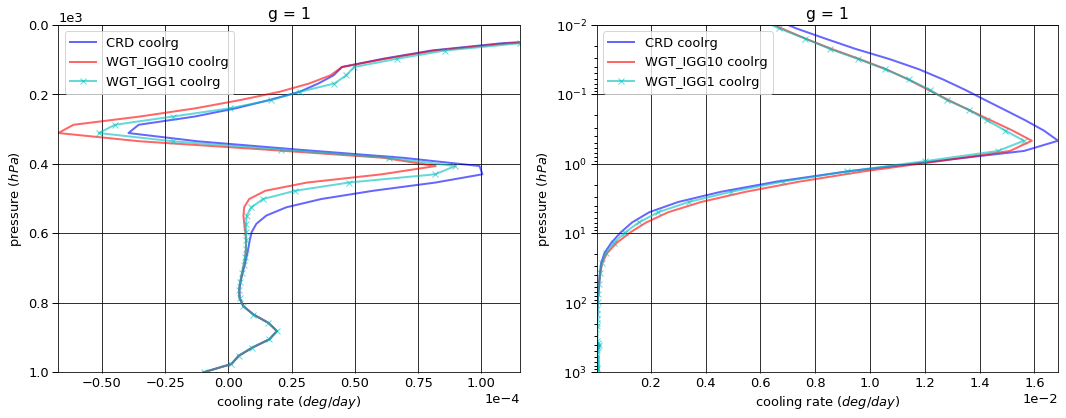

# Figure: cooling rate g-group 2

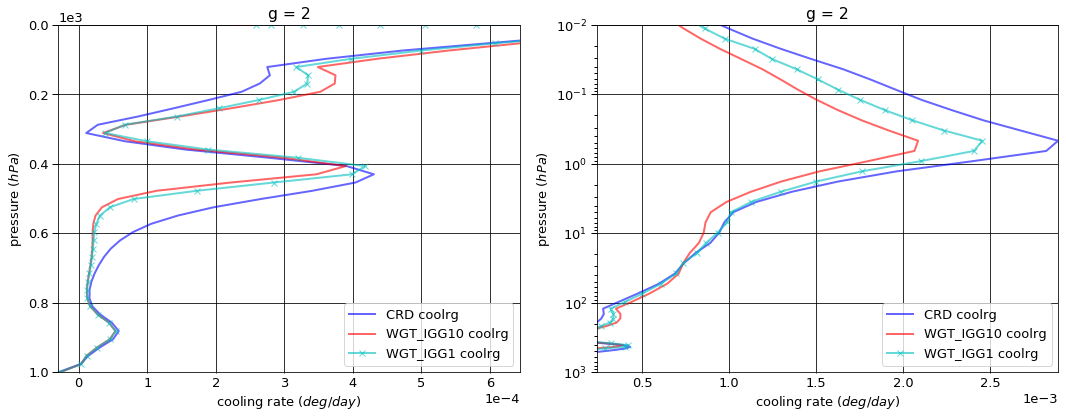

# Figure: cooling rate g-group 3

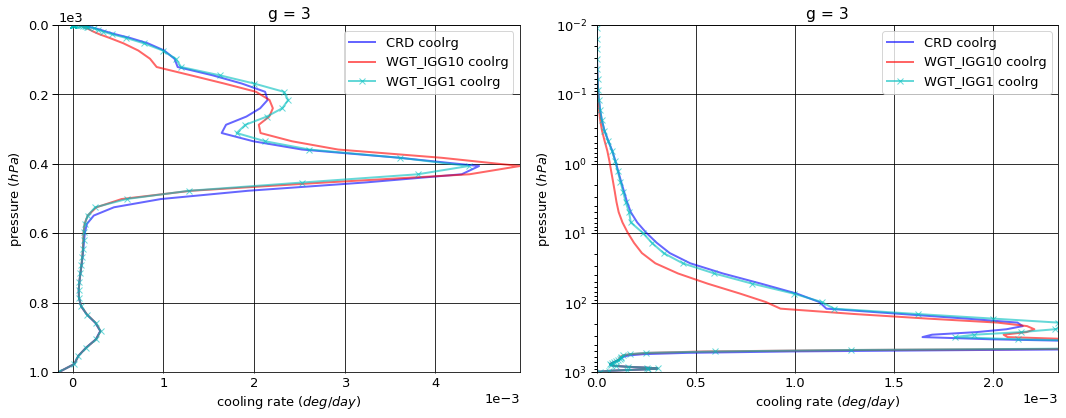

# Figure: cooling rate g-group 4

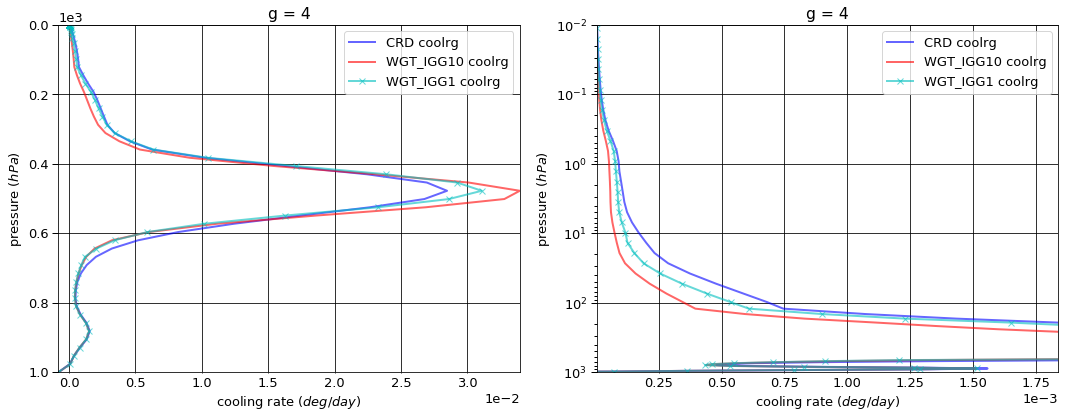

# Figure: cooling rate g-group 5

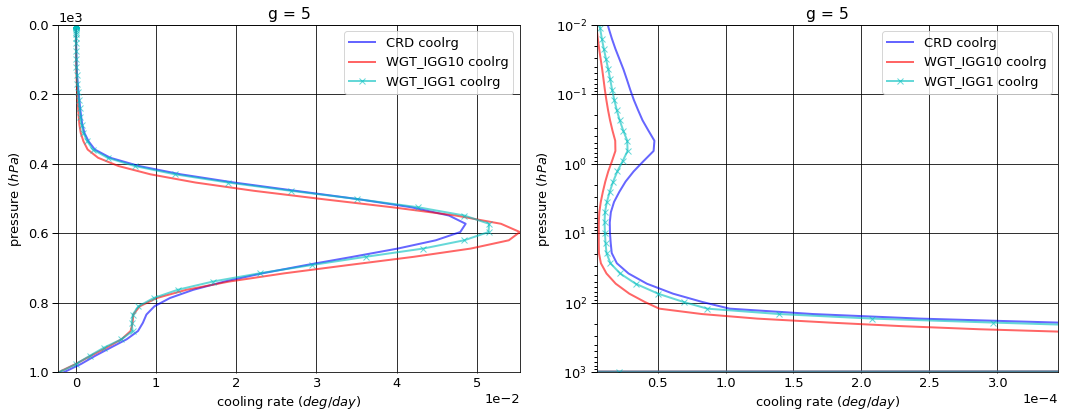

# Figure: cooling rate g-group 6

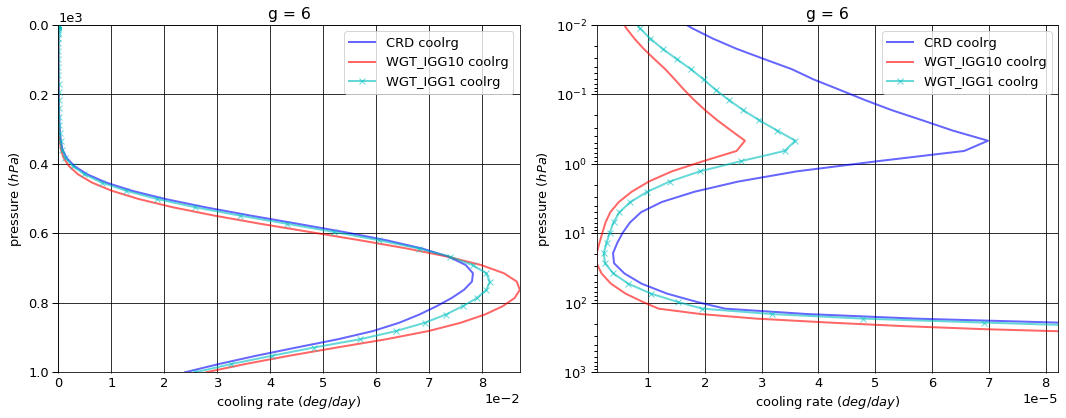

# Figure: cooling rate g-group 7

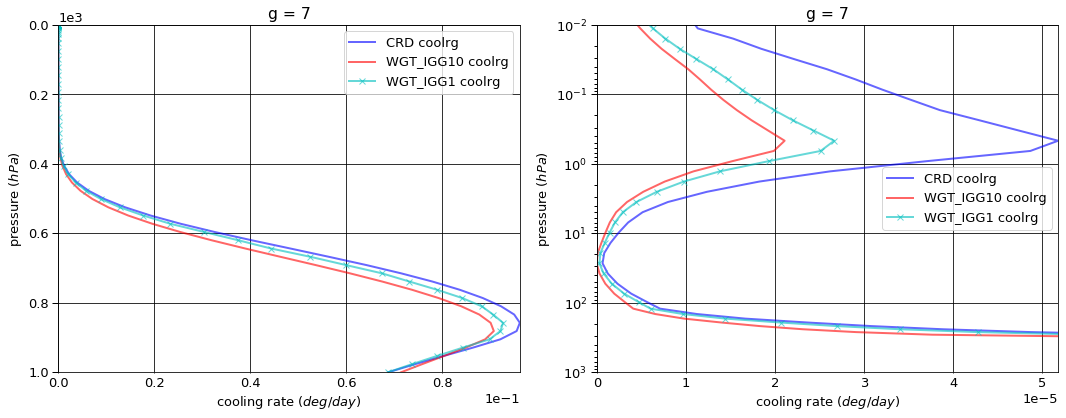

# Figure: cooling rate g-group 8

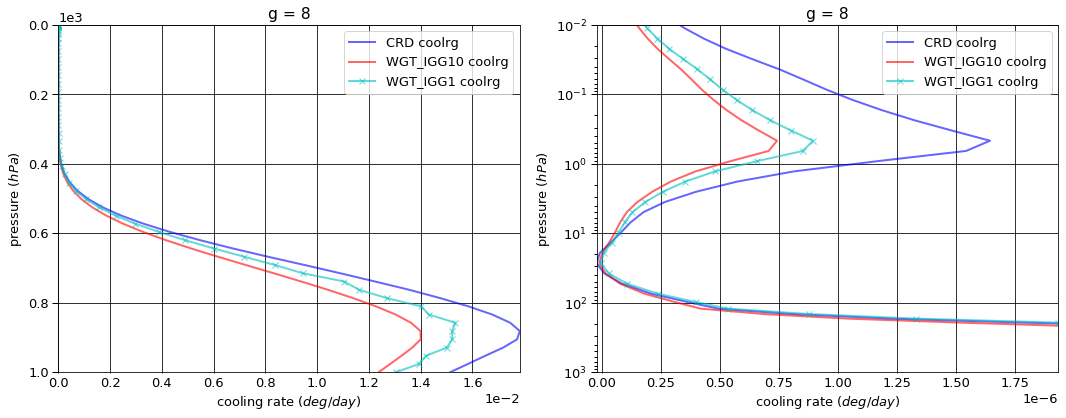

# Figure: cooling rate g-group total

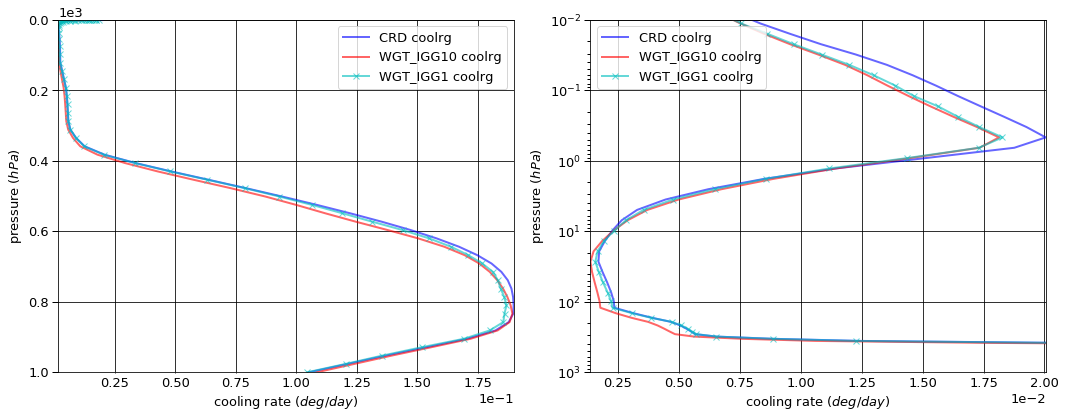

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008278  0.000000  -0.008278
  1013.0   76     -0.013316  0.013380   0.000064
2 0.0      1      -0.021636  0.000000  -0.021636
  1013.0   76     -0.037286  0.037485   0.000199
3 0.0      1      -0.127406  0.000000  -0.127406
  1013.0   76     -0.214188  0.215191   0.001002
4 0.0      1      -0.681178  0.000000  -0.681178
  1013.0   76     -0.958846  0.964069   0.005223
5 0.0      1      -1.573918  0.000000  -1.573918
  1013.0   76     -1.877660  1.893417   0.015757
6 0.0      1      -4.183651  0.000000  -4.183651
  1013.0   76     -4.434165  3.798316  -0.635849
7 0.0      1     -10.562514  0.000000 -10.562514
  1013.0   76    -10.694612  4.151555  -6.543057
8 0.0      1      -5.345120  0.000000  -5.345120
  1013.0   76     -5.361064  0.709321  -4.651743


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008106  0.000000  -0.008106
  1013.0   76     -0.013325  0.013388   0.000063
2 0.0      1      -0.020409  0.000000  -0.020409
  1013.0   76     -0.037314  0.037490   0.000176
3 0.0      1      -0.125752  0.000000  -0.125752
  1013.0   76     -0.214385  0.215395   0.001010
4 0.0      1      -0.685740  0.000000  -0.685740
  1013.0   76     -0.959606  0.964673   0.005067
5 0.0      1      -1.590311  0.000000  -1.590311
  1013.0   76     -1.879442  1.899953   0.020511
6 0.0      1      -4.221644  0.000000  -4.221644
  1013.0   76     -4.438491  3.956242  -0.482250
7 0.0      1     -10.600513  0.000000 -10.600513
  1013.0   76    -10.698933  3.741643  -6.957291
8 0.0      1      -5.337919  0.000000  -5.337919
  1013.0   76     -5.349641  0.553757  -4.795884


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008104  0.000000  -0.008104
  1013.0   76     -0.013325  0.013388   0.000063
2 0.0      1      -0.020641  0.000000  -0.020641
  1013.0   76     -0.037314  0.037490   0.000177
3 0.0      1      -0.124645  0.000000  -0.124645
  1013.0   76     -0.214385  0.215395   0.001010
4 0.0      1      -0.674887  0.000000  -0.674887
  1013.0   76     -0.959606  0.964665   0.005059
5 0.0      1      -1.568577  0.000000  -1.568577
  1013.0   76     -1.879442  1.898670   0.019227
6 0.0      1      -4.194554  0.000000  -4.194554
  1013.0   76     -4.438491  3.892061  -0.546431
7 0.0      1     -10.577137  0.000000 -10.577137
  1013.0   76    -10.698933  3.962451  -6.736483
8 0.0      1      -5.335338  0.000000  -5.335338
  1013.0   76     -5.349641  0.619521  -4.730120


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000172  0.000000  1.723589e-04
  1013.0   76    -0.000009  0.000008 -8.927400e-07
2 0.0      1      0.001227  0.000000  1.226949e-03
  1013.0   76    -0.000028  0.000005 -2.325889e-05
3 0.0      1      0.001654  0.000000  1.653990e-03
  1013.0   76    -0.000197  0.000204  7.651600e-06
4 0.0      1     -0.004562  0.000000 -4.561950e-03
  1013.0   76    -0.000760  0.000604 -1.558841e-04
5 0.0      1     -0.016394  0.000000 -1.639380e-02
  1013.0   76    -0.001782  0.006536  4.753151e-03
6 0.0      1     -0.037993  0.000000 -3.799250e-02
  1013.0   76    -0.004326  0.157926  1.535998e-01
7 0.0      1     -0.037999  0.000000 -3.799900e-02
  1013.0   76    -0.004321 -0.409913 -4.142339e-01
8 0.0      1      0.007202  0.000000  7.201600e-03
  1013.0   76     0.011423 -0.155564 -1.441409e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000175  0.000000  1.745262e-04
  1013.0   76    -0.000009  0.000008 -8.934670e-07
2 0.0      1      0.000995  0.000000  9.946990e-04
  1013.0   76    -0.000028  0.000006 -2.239842e-05
3 0.0      1      0.002762  0.000000  2.761510e-03
  1013.0   76    -0.000197  0.000204  7.284600e-06
4 0.0      1      0.006291  0.000000  6.290860e-03
  1013.0   76    -0.000760  0.000596 -1.638366e-04
5 0.0      1      0.005341  0.000000  5.340900e-03
  1013.0   76    -0.001782  0.005252  3.469725e-03
6 0.0      1     -0.010903  0.000000 -1.090250e-02
  1013.0   76    -0.004326  0.093745  8.941866e-02
7 0.0      1     -0.014623  0.000000 -1.462300e-02
  1013.0   76    -0.004321 -0.189105 -1.934259e-01
8 0.0      1      0.009783  0.000000  9.782600e-03
  1013.0   76     0.011423 -0.089799 -7.837650e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.755893e-03
  1001.112500 75    -9.853299e-06
2 0.000312    1      2.618170e-04
  1001.112500 75    -2.972642e-05
3 0.000312    1      5.930151e-09
  1001.112500 75    -1.550104e-04
4 0.000312    1      6.983311e-07
  1001.112500 75    -8.085491e-04
5 0.000312    1      2.421996e-06
  1001.112500 75    -1.502865e-03
6 0.000312    1      1.911566e-06
  1001.112500 75     2.390357e-02
7 0.000312    1      2.230394e-07
  1001.112500 75     6.868383e-02
8 0.000312    1     -1.702756e-08
  1001.112500 75     1.513164e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.959692e-03
  1001.112500 75    -9.708804e-06
2 0.000312    1      2.237580e-04
  1001.112500 75    -2.720819e-05
3 0.000312    1      3.794951e-09
  1001.112500 75    -1.562409e-04
4 0.000312    1      3.849243e-07
  1001.112500 75    -7.997554e-04
5 0.000312    1      6.112359e-07
  1001.112500 75    -2.179156e-03
6 0.000312    1      1.283671e-07
  1001.112500 75     2.787222e-02
7 0.000312    1     -1.292317e-07
  1001.112500 75     7.137896e-02
8 0.000312    1     -6.592475e-09
  1001.112500 75     1.237207e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.777186e-03
  1001.112500 75    -9.708759e-06
2 0.000312    1      2.586793e-04
  1001.112500 75    -2.734645e-05
3 0.000312    1      5.676479e-09
  1001.112500 75    -1.561980e-04
4 0.000312    1      6.384974e-07
  1001.112500 75    -7.972727e-04
5 0.000312    1      1.191308e-06
  1001.112500 75    -2.055956e-03
6 0.000312    1      4.870747e-07
  1001.112500 75     2.581369e-02
7 0.000312    1     -2.999636e-08
  1001.112500 75     6.867565e-02
8 0.000312    1     -6.268255e-09
  1001.112500 75     1.303904e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.037992e-04
  1001.112500 75     1.444950e-07
2 0.000312    1     -3.805898e-05
  1001.112500 75     2.518222e-06
3 0.000312    1     -2.135199e-09
  1001.112500 75    -1.230490e-06
4 0.000312    1     -3.134068e-07
  1001.112500 75     8.793680e-06
5 0.000312    1     -1.810760e-06
  1001.112500 75    -6.762907e-04
6 0.000312    1     -1.783199e-06
  1001.112500 75     3.968649e-03
7 0.000312    1     -3.522711e-07
  1001.112500 75     2.695130e-03
8 0.000312    1      1.043508e-08
  1001.112500 75    -2.759576e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.129230e-05
  1001.112500 75     1.445394e-07
2 0.000312    1     -3.137650e-06
  1001.112500 75     2.379970e-06
3 0.000312    1     -2.536722e-10
  1001.112500 75    -1.187550e-06
4 0.000312    1     -5.983362e-08
  1001.112500 75     1.127635e-05
5 0.000312    1     -1.230689e-06
  1001.112500 75    -5.530910e-04
6 0.000312    1     -1.424491e-06
  1001.112500 75     1.910112e-03
7 0.000312    1     -2.530358e-07
  1001.112500 75    -8.177000e-06
8 0.000312    1      1.075930e-08
  1001.112500 75    -2.092600e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.503702,0.000000,-22.503702
1013.0,76,-23.591138,11.782735,-11.808403



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.590394,0.00000,-22.590394
1013.0,76,-23.591137,11.38254,-12.208598



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.503882,0.000000,-22.503882
1013.0,76,-23.591137,11.603641,-11.987497



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.669235e-02,0.000000,-0.086692
1013.0,76,2.770000e-07,-0.400194,-0.400194



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.804048e-04,0.000000,-0.000180
1013.0,76,2.770000e-07,-0.179094,-0.179094


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.002023
1001.112500,75,0.105213



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.002184
1001.112500,75,0.108451



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.002038
1001.112500,75,0.104482



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000161
1001.112500,75,0.003238



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000015
1001.112500,75,-0.000731


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000562,0.000565
2,0.001575,0.001582
3,0.009038,0.009088
4,0.040488,0.040677
5,0.079250,0.079667
6,0.187112,0.188142
7,0.452450,0.453515
8,0.229525,0.226765


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.203448e-19
2,1.293116e-20
3,5.751102e-21
4,1.054900e-21
5,1.934958e-22
6,3.549211e-23
7,6.510165e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.203448e-19,NaN,0.000562,0.000565,0.000562,0.000565,10.0
2,1.293116e-20,0.107451,0.001575,0.001582,0.002138,0.002147,10.0
3,5.751102e-21,0.444747,0.009038,0.009088,0.011175,0.011234,600.0
4,1.054900e-21,0.183426,0.040488,0.040677,0.051663,0.051911,600.0
5,1.934958e-22,0.183426,0.079250,0.079667,0.130912,0.131578,600.0
6,3.549211e-23,0.183426,0.187112,0.188142,0.318025,0.319720,600.0
7,6.510165e-24,0.183426,0.452450,0.453515,0.770475,0.773235,600.0
8,1.194132e-24,0.183426,0.229525,0.226765,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
